In [1]:
import json
import os
import sys
import pickle
import re

import numpy as np
import pandas as pd
from networks import DualNet, DualNetEndToEnd, PrimalNet, PrimalNetEndToEnd
import torch
from gep_config_parser import parse_config


ARGS_FILE_NAME = "config.json"
CONFIG_FILE_NAME = "config.toml"

with open(ARGS_FILE_NAME, "r") as file:
        args = json.load(file)

ED_args = args["ED_args"]

input_data = parse_config(CONFIG_FILE_NAME) # Reads the input data using config.toml's experiment.inputs.data path.

gep_ed_data = input_data["experiment"]["experiments"][0] # Take first experiment, we don't change the inputs here.

if args["problem_type"] == "ED":
    #! TODO: not all configs are correctly parsed here. E.g. when first running BEL and GER with both coal generators, is the same as with both gas generators.
    # For nodes, just use first letters: ['BEL', 'GER', 'NED'] → 'B-G-N'
    nodes_str = "-".join([n[0] for n in ED_args['N']])
    
    # For generators, count per node: [['BEL', 'WindOn'], ['BEL', 'Gas'],...] = 'B3-G2-N2'
    gen_counts = {}
    for g in ED_args['G']:
        node = g[0]
        gen_counts[node] = gen_counts.get(node, 0) + 1
    gens_str = "-".join([f"{node[0]}{count}" for node, count in gen_counts.items()])
    
    # For lines, just count: [['BEL', 'GER'], ['BEL', 'NED'], ['GER', 'NED']] → 'L3'
    lines_str = f"L{len(ED_args['L'])}"
    
    # Create a shortened filename
    data_save_path = (f"data/ED_data/ED_N{nodes_str}_G{gens_str}_{lines_str}"
                    f"_c{int(ED_args['benders_compact'])}"
                    f"_s{int(ED_args['scale_problem'])}"
                    f"_p{int(ED_args['perturb_operating_costs'])}"
                    f"_smp{ED_args['2n_synthetic_samples']}.pkl")

def evaluate(data, primal_net, test_indices):        
    X = data.X[test_indices]
    Y_target = data.opt_targets["y_operational"][test_indices]
    
    # Forward pass through networks
    Y = primal_net(X)

    ineq_dist = data.ineq_dist(X, Y)
    eq_resid = data.eq_resid(X, Y)

    relative_ineq_dist = data.relative_ineq_dist(X, Y)
    relative_eq_resid = data.relative_eq_resid(X, Y)

    # Convert lists to arrays for easier handling
    obj_values = data.obj_fn(X, Y).detach().numpy()
    ineq_max_vals = torch.max(ineq_dist, dim=1)[0].detach().numpy() # First element is the max, second is the index
    ineq_mean_vals = torch.mean(ineq_dist, dim=1).detach().numpy()
    eq_max_vals = torch.max(torch.abs(eq_resid), dim=1)[0].detach().numpy() # First element is the max, second is the index
    eq_mean_vals = torch.mean(torch.abs(eq_resid), dim=1).detach().numpy()

    relative_ineq_max_vals = torch.max(relative_ineq_dist, dim=1)[0].detach().numpy() # First element is the max, second is the index
    relative_ineq_mean_vals = torch.mean(relative_ineq_dist, dim=1).detach().numpy()
    relative_eq_max_vals = torch.max(torch.abs(relative_eq_resid), dim=1)[0].detach().numpy() # First element is the max, second is the index
    relative_eq_mean_vals = torch.mean(torch.abs(relative_eq_resid), dim=1).detach().numpy()

    known_obj = data.obj_fn(X, Y_target).detach().numpy()
    # obj_values is negative
    opt_gap = (obj_values - known_obj)/np.abs(known_obj) * 100

    return np.mean(obj_values), np.mean(known_obj), np.mean(opt_gap), np.mean(ineq_max_vals), np.mean(relative_ineq_max_vals), np.mean(ineq_mean_vals), np.mean(relative_ineq_mean_vals), np.mean(eq_max_vals), np.mean(relative_eq_max_vals), np.mean(eq_mean_vals), np.mean(relative_eq_mean_vals)

def dual_evaluate(data, dual_net, test_indices):
    X = data.X[test_indices]
    # target_mu = data.mu[test_indices]
    # target_lamb = data.lamb[test_indices]
    target_mu = data.opt_targets["mu_operational"][test_indices]  
    target_lamb = data.opt_targets["lamb_operational"][test_indices]
    print(X.dtype)
    print(dual_net.net[0].weight.dtype)

    # Forward pass through networks
    mu, lamb = dual_net(X)

    obj_values = data.dual_obj_fn(X, mu, lamb).detach().numpy()
    known_obj = data.dual_obj_fn(X, target_mu, target_lamb).detach().numpy()
    # dual_ineq_dist = data.dual_ineq_dist(mu, lamb)
    dual_ineq_resid = data.dual_ineq_resid(mu, lamb)
    dual_ineq_dist = torch.clamp(dual_ineq_resid, 0)
    dual_eq_resid = data.dual_eq_resid(mu, lamb)

    opt_gap = (obj_values - known_obj)/np.abs(known_obj) * 100

    ineq_max_vals = torch.max(dual_ineq_dist, dim=1)[0].detach().numpy() # First element is the max, second is the index
    eq_max_vals = torch.max(torch.abs(dual_eq_resid), dim=1)[0].detach().numpy() # First element is the max, second is the index
    ineq_mean_vals = torch.mean(dual_ineq_dist, dim=1).detach().numpy()
    eq_mean_vals = torch.mean(torch.abs(dual_eq_resid), dim=1).detach().numpy()

    return np.mean(obj_values), np.mean(known_obj), np.mean(opt_gap), np.mean(ineq_max_vals), np.mean(ineq_mean_vals), np.mean(eq_max_vals), np.mean(eq_mean_vals)

repeats = 1
stats_dict = {}

# args = json.load(open('config.json'))
data_path = f"experiment-output/ch5/ED_NB-G-F_GB2-G2-F2_L3_c0_s0_p0_smp15.pkl"
data = pickle.load(open(data_path, 'rb'))

indices = torch.arange(data.X.shape[0])

exp_paths = [
    "outputs/PDL/ED/learn_primal:True_train:0.8_rho:0.5_rhomax:5000_alpha:10_L:10-NoPowerBlanaceRepairNoNorm",
    "outputs/PDL/ED/learn_primal:True_train:0.8_rho:0.5_rhomax:5000_alpha:10_L:10-NoNormRepairAll",
    "outputs/PDL/ED/learn_primal:True_train:0.8_rho:0.5_rhomax:5000_alpha:10_L:10-NormRepairAll",
    "outputs/PDL/ED/learn_primal:True_train:0.8_rho:0.5_rhomax:5000_alpha:10_L:10-NormRepairWithoutGT",
    "outputs/PDL/ED/learn_primal:True_train:0.8_rho:0.5_rhomax:5000_alpha:10_L:10-DualityGap",
    "outputs/PDL/ED/learn_primal:True_train:0.8_rho:0.5_rhomax:5000_alpha:10_L:10-DualityGapNormMiddle",
    "outputs/PDL/ED/learn_primal:True_train:0.8_rho:0.5_rhomax:5000_alpha:10_L:10-Log",
]

ARGS_FILE_NAME = "config.json"

# for run, (path, name) in enumerate(zip(["experiment-output/ch5/plain-PDL/learn_primal:True_train:0.8_rho:0.5_rhomax:5000_alpha:10_L:10-1746265816-296861",
#              "experiment-output/ch5/repair-1/learn_primal:True_train:0.8_rho:0.5_rhomax:5000_alpha:10_L:10-1746429988-424426",
#              "experiment-output/ch5/repair-2/learn_primal:True_train:0.8_rho:0.5_rhomax:5000_alpha:10_L:10-1746434902-974866"],
#             ["plain", "repair1", "repair2"])):

for run, (path, name) in enumerate(zip(exp_paths,
            ["NoPowerBalanceRepair", "RepairAll-NoNorm", "RepairAll-NormwithGT","RepairAll-NormwithObj","RepairAll-DualityGap","DualityGapNormMiddle","RepairAll-Log"])):
    stats_dict[name] = {"predicted_obj": [], "known_obj": [], "opt_gap": [], "ineq_max": [], "ineq_mean": [], "eq_max": [], "eq_mean": [], "relative_ineq_max": [], "relative_ineq_mean": [], "relative_eq_max": [], "relative_eq_mean": []}
    with open(os.path.join(path, 'args.json'), 'r') as f:
        args = json.load(f)
    # with open(ARGS_FILE_NAME, "r") as file:
    #     args = json.load(file)
    # Compute sizes for each set
    train_size = int(args["train"] * data.X.shape[0])
    valid_size = int(args["valid"] * data.X.shape[0])
    # print(f"Train size: {train_size}, Valid size: {valid_size}, Test size: {data.X.shape[0] - train_size - valid_size}")


    # Split the indices
    train_indices = indices[:train_size]
    valid_indices = indices[train_size:train_size+valid_size]
    test_indices = indices[train_size+valid_size:]

    args["hidden_size_factor"] = 28 # Set as this for some reason

    for i, repeat in enumerate(range(repeats)):
        
        directory = os.path.join(path, f"repeat:{repeat}")
        # directory = f"experiment-output/ch5-reproduction-nonconvex/{experiment}/repeat:{repeat}"
        # dual_net = DualNet(args, data=data)
        # dual_net.load_state_dict(torch.load(os.path.join(directory, 'dual_weights.pth'), weights_only=True))
        print(f"Data xdim: {data.xdim}, layer: { args["n_layers"]} hidden size factro : {args["hidden_size_factor"]} hid size: {[int(args["hidden_size_factor"]*data.xdim)] * args["n_layers"]}")
        primal_net = PrimalNetEndToEnd(args, data=data)
        
        primal_net.load_state_dict(torch.load(os.path.join(directory, 'primal_weights.pth'), weights_only=True))
        # obj_val, known_obj, opt_gap, ineq_max, ineq_mean, eq_max, eq_mean = dual_evaluate(data, dual_net, test_indices)
        obj_val, known_obj, opt_gap, ineq_max, relative_ineq_max, ineq_mean, relative_ineq_mean, eq_max, relative_eq_max, eq_mean, relative_eq_mean = evaluate(data, primal_net, test_indices)
        stats_dict[name]["predicted_obj"].append(obj_val)
        stats_dict[name]["known_obj"].append(known_obj)
        stats_dict[name]["opt_gap"].append(opt_gap)
        stats_dict[name]["ineq_max"].append(ineq_max)
        stats_dict[name]["ineq_mean"].append(ineq_mean)
        stats_dict[name]["eq_max"].append(eq_max)
        stats_dict[name]["eq_mean"].append(eq_mean)
        stats_dict[name]["relative_ineq_max"].append(relative_ineq_max)
        stats_dict[name]["relative_ineq_mean"].append(relative_ineq_mean)
        stats_dict[name]["relative_eq_max"].append(relative_eq_max)
        stats_dict[name]["relative_eq_mean"].append(relative_eq_mean)


stats_dict

        

Data xdim: 9, layer: 2 hidden size factro : 28 hid size: [252, 252]
Data xdim: 9, layer: 2 hidden size factro : 28 hid size: [252, 252]
Data xdim: 9, layer: 2 hidden size factro : 28 hid size: [252, 252]
Data xdim: 9, layer: 2 hidden size factro : 28 hid size: [252, 252]
Data xdim: 9, layer: 2 hidden size factro : 28 hid size: [252, 252]
Data xdim: 9, layer: 2 hidden size factro : 28 hid size: [252, 252]
Data xdim: 9, layer: 2 hidden size factro : 28 hid size: [252, 252]


{'NoPowerBalanceRepair': {'predicted_obj': [np.float64(132871.993442152)],
  'known_obj': [np.float64(29293.887262458353)],
  'opt_gap': [np.float64(5072.777545920074)],
  'ineq_max': [np.float64(14.678741345584145)],
  'ineq_mean': [np.float64(0.629894748919529)],
  'eq_max': [np.float64(2.371678069174799e-12)],
  'eq_mean': [np.float64(9.127316668494031e-13)],
  'relative_ineq_max': [np.float64(0.0012480352170726012)],
  'relative_ineq_mean': [np.float64(5.3112162532872004e-05)],
  'relative_eq_max': [np.float64(6.665770486994394e-17)],
  'relative_eq_mean': [np.float64(2.615066649631913e-17)]},
 'RepairAll-NoNorm': {'predicted_obj': [np.float64(29335.206144498316)],
  'known_obj': [np.float64(29293.887262458353)],
  'opt_gap': [np.float64(1.9907068470519729)],
  'ineq_max': [np.float64(3.007186798403259e-12)],
  'ineq_mean': [np.float64(1.4702757800930573e-13)],
  'eq_max': [np.float64(2.6308202447257187e-12)],
  'eq_mean': [np.float64(9.942107020600954e-13)],
  'relative_ineq_max':

In [2]:
print(stats_dict['AllRepair-NormTrue'].keys())
print("Inque Max:")
print(stats_dict['AllRepair-NormTrue']['ineq_max'])
print(stats_dict['AllRepair-NormFalse']['ineq_max'])
print("Inque Mean:")
print(stats_dict['AllRepair-NormTrue']['ineq_mean'])
print(stats_dict['AllRepair-NormFalse']['ineq_mean'])


KeyError: 'AllRepair-NormTrue'

In [ ]:

# Convert stats_dict → table
table_rows = []

for exp_name, metrics in stats_dict.items():
    row = {"experiment": exp_name}

    for key, value in metrics.items():
        # value is often [np.float64(...)] so extract scalar
        if isinstance(value, list) and len(value) == 1:
            row[key] = float(value[0])
        else:
            row[key] = value

    table_rows.append(row)

df = pd.DataFrame(table_rows)

# Set experiment name as index
df = df.set_index("experiment")

df = df.round(4)

df


,predicted_obj,known_obj,opt_gap,ineq_max,ineq_mean,eq_max,eq_mean,relative_ineq_max,relative_ineq_mean,relative_eq_max,relative_eq_mean
experiment,,,,,,,,,,,
NoPowerBalanceRepair,132871.9934,29293.8873,5072.7775,14.6787,0.6299,0.0,0.0,0.0012,0.0001,0.0,0.0
RepairAll-NoNorm,29335.2061,29293.8873,1.9907,0.0000,0.0000,0.0,0.0,0.0000,0.0000,0.0,0.0
RepairAll-NormwithGT,29307.6559,29293.8873,0.6017,0.2615,0.0109,0.0,0.0,0.0000,0.0000,0.0,0.0
RepairAll-NormwithObj,29309.6711,29293.8873,0.7142,0.0000,0.0000,0.0,0.0,0.0000,0.0000,0.0,0.0
RepairAll-DualityGap,29310.5084,29293.8873,0.6904,0.6494,0.0271,0.0,0.0,0.0000,0.0000,0.0,0.0
DualityGapNormMiddle,30161.4939,29293.8873,26.6520,0.0000,0.0000,0.0,0.0,0.0000,0.0000,0.0,0.0
RepairAll-Log,29310.3676,29293.8873,0.6902,0.0376,0.0016,0.0,0.0,0.0000,0.0000,0.0,0.0


In [ ]:
df2 = df.copy()
drop_cols = [
    "ineq_mean",
    "eq_mean",
    "relative_ineq_mean",
    "relative_eq_mean"
]
mean_cols = {}
for col in df2.columns:
    if isinstance(df2[col].iloc[0], (list, np.ndarray)):
        # compute mean + std
        means = df2[col].apply(lambda x: float(np.mean(x)))
        stds  = df2[col].apply(lambda x: float(np.std(x)))
        mean_cols[col] = (means, stds)

# Build the formatted dataframe
formatted = pd.DataFrame(index=df2.index)

for col, (means, stds) in mean_cols.items():
    formatted[col] = means.round(4).astype(str) + " (" + stds.round(4).astype(str) + ")"

formatted

""
experiment
NoPowerBalanceRepair
RepairAll-NoNorm
RepairAll-NormwithGT
RepairAll-NormwithObj
RepairAll-DualityGap
DualityGapNormMiddle
RepairAll-Log


In [ ]:
!pip install scipy

In [ ]:
# Prepare separate dictionaries
objective_summary = {"Experiment": [], "Optimal Obj": [], "Predicted Obj": [], "OptGap (%)": []}
regular_summary = {"Experiment": [], "IneqMax": [], "IneqMean": [], "EqMax": [], "EqMean": []}
relative_summary = {"Experiment": [], "Relative IneqMax": [], "Relative IneqMean": [], "Relative EqMax": [], "Relative EqMean": []}

for experiment, metrics in stats_dict.items():
    objective_summary["Experiment"].append(experiment)
    objective_summary["Optimal Obj"].append(f"{np.mean(metrics['known_obj']):.3f}")
    objective_summary["Predicted Obj"].append(f"{np.mean(metrics['predicted_obj']):.3f}({np.std(metrics['predicted_obj']):.3f})")
    objective_summary["OptGap (%)"].append(f"{np.mean(metrics['opt_gap']):.3f}({np.std(metrics['opt_gap']):.3f})")

    regular_summary["Experiment"].append(experiment)
    regular_summary["IneqMax"].append(f"{np.mean(metrics['ineq_max']):.3f}({np.std(metrics['ineq_max']):.3f})")
    regular_summary["IneqMean"].append(f"{np.mean(metrics['ineq_mean']):.3f}({np.std(metrics['ineq_mean']):.3f})")
    regular_summary["EqMax"].append(f"{np.mean(metrics['eq_max']):.3f}({np.std(metrics['eq_max']):.3f})")
    regular_summary["EqMean"].append(f"{np.mean(metrics['eq_mean']):.3f}({np.std(metrics['eq_mean']):.3f})")

    relative_summary["Experiment"].append(experiment)
    relative_summary["Relative IneqMax"].append(f"{np.mean(metrics['relative_ineq_max']):.3f}({np.std(metrics['relative_ineq_max']):.3f})")
    relative_summary["Relative IneqMean"].append(f"{np.mean(metrics['relative_ineq_mean']):.3f}({np.std(metrics['relative_ineq_mean']):.3f})")
    relative_summary["Relative EqMax"].append(f"{np.mean(metrics['relative_eq_max']):.3f}({np.std(metrics['relative_eq_max']):.3f})")
    relative_summary["Relative EqMean"].append(f"{np.mean(metrics['relative_eq_mean']):.3f}({np.std(metrics['relative_eq_mean']):.3f})")

# Convert to DataFrames
df_obj = pd.DataFrame(objective_summary)
df_regular = pd.DataFrame(regular_summary)
df_relative = pd.DataFrame(relative_summary)

# Export LaTeX tables
latex_obj = df_obj.to_latex(index=False, escape=False)
latex_regular = df_regular.to_latex(index=False, escape=False)
latex_relative = df_relative.to_latex(index=False, escape=False)

# Print or write to file
# print("% Objective Table")
# print(latex_obj)
print("----------------")
print("\n% Regular Constraint Table")
print(latex_regular)
print("----------------")
print("\n% Relative Constraint Table")
print(latex_relative)

----------------

% Regular Constraint Table
\begin{tabular}{lllll}
\toprule
Experiment & IneqMax & IneqMean & EqMax & EqMean \\
\midrule
AllRepair-NormTrue & 0.261(0.000) & 0.011(0.000) & 0.000(0.000) & 0.000(0.000) \\
AllRepair-NormFalse & 0.000(0.000) & 0.000(0.000) & 0.000(0.000) & 0.000(0.000) \\
AllRepair-NormTrueNoGT & 0.000(0.000) & 0.000(0.000) & 0.000(0.000) & 0.000(0.000) \\
DualityGapNorm & 0.649(0.000) & 0.027(0.000) & 0.000(0.000) & 0.000(0.000) \\
DualityGapNoNorm & 0.000(0.000) & 0.000(0.000) & 0.000(0.000) & 0.000(0.000) \\
DualityGapNormMiddle & 0.000(0.000) & 0.000(0.000) & 0.000(0.000) & 0.000(0.000) \\
NoPowerBalanceRepair & 14.679(0.000) & 0.630(0.000) & 0.000(0.000) & 0.000(0.000) \\
DualClassification & 0.000(0.000) & 0.000(0.000) & 0.000(0.000) & 0.000(0.000) \\
Log & 0.038(0.000) & 0.002(0.000) & 0.000(0.000) & 0.000(0.000) \\
\bottomrule
\end{tabular}

----------------

% Relative Constraint Table
\begin{tabular}{lllll}
\toprule
Experiment & Relative IneqMax 

In [3]:
# Get the quality of dual solutions:
dual_stats_dict = {}
for experiment in ["simple"]:
    dual_stats_dict[experiment] = {"obj": [], "known_obj": [], "opt_gap": [], "ineq_max": [], "ineq_mean": [], "eq_max": [], "eq_mean": []}
    for repeat in range(repeats):
        directory = f"experiment-output/ch4/ch4-reproduction/{experiment}/repeat:{repeat}"
        data_path = f"data/QP_data/QP_type:{experiment}_var:100_ineq:50_eq:50_num_samples:10000.pkl"

        args = json.load(open('config.json'))
        data = pickle.load(open(data_path, 'rb'))
        dual_net = DualNet(args, data=data)
        dual_net.load_state_dict(torch.load(os.path.join(directory, 'dual_weights.pth'), weights_only=True))

        obj_val, known_obj, opt_gap, ineq_max, ineq_mean, eq_max, eq_mean = dual_evaluate(data, dual_net, data.test_indices)
        dual_stats_dict[experiment]["obj"].append(obj_val)
        dual_stats_dict[experiment]["known_obj"].append(known_obj)
        dual_stats_dict[experiment]["opt_gap"].append(opt_gap)
        dual_stats_dict[experiment]["ineq_max"].append(ineq_max)
        dual_stats_dict[experiment]["ineq_mean"].append(ineq_mean)
        dual_stats_dict[experiment]["eq_max"].append(eq_max)
        dual_stats_dict[experiment]["eq_mean"].append(eq_mean)

dual_stats_dict

/Users/peterhuang/Desktop/Delft/Year-2/masterthesis/QP_problem.py:408: SyntaxWarning: invalid escape sequence '\l'
  """-1/2(p + A^T\lambda + G^T\mu)^T Q^-1(p + A^T\lambda + G^T\mu) - \lambda^T X[i] - \mu^Td


ModuleNotFoundError: No module named 'osqp'

In [ ]:
# Prepare final summary for LaTeX export
summary = {
    "Optimal Obj": [],
    "Predicted Obj": [],
    "OptGap (\%)": [],
    "IneqMax": [],
    "IneqMean": [],
    "EqMax": [],
    "EqMean": [],
}

for experiment, metrics in dual_stats_dict.items():
    summary["Optimal Obj"].append(f"{np.mean(metrics['known_obj']):.3f}")
    summary["Predicted Obj"].append(f"{np.mean(metrics['obj']):.3e}({np.std(metrics['obj']):.3e})")
    summary["OptGap (\%)"].append(f"{np.mean(metrics['opt_gap']):.3e}({np.std(metrics['opt_gap']):.3e})")
    summary["IneqMax"].append(
        f"{np.mean(metrics['ineq_max']):.3f}({np.std(metrics['ineq_max']):.3f})"
    )
    summary["IneqMean"].append(
        f"{np.mean(metrics['ineq_mean']):.3f}({np.std(metrics['ineq_mean']):.3f})"
    )
    summary["EqMax"].append(
        f"{np.mean(metrics['eq_max']):.3f}({np.std(metrics['eq_max']):.3f})"
    )
    summary["EqMean"].append(
        f"{np.mean(metrics['eq_mean']):.3f}({np.std(metrics['eq_mean']):.3f})"
    )

df = pd.DataFrame(summary)

# For LaTeX export
latex_table = df.to_latex(index=False, escape=False)
print(latex_table)

\begin{tabular}{lllllll}
\toprule
Optimal Obj & Predicted Obj & OptGap (\%) & IneqMax & IneqMean & EqMax & EqMean \\
\midrule
nan & nan(nan) & nan(nan) & nan(nan) & nan(nan) & nan(nan) & nan(nan) \\
\bottomrule
\end{tabular}



<>:5: SyntaxWarning: invalid escape sequence '\%'
<>:15: SyntaxWarning: invalid escape sequence '\%'
<>:5: SyntaxWarning: invalid escape sequence '\%'
<>:15: SyntaxWarning: invalid escape sequence '\%'
/var/folders/3n/3c918lz14kd61yk6hgz4s1x40000gn/T/ipykernel_17478/4066793788.py:5: SyntaxWarning: invalid escape sequence '\%'
  "OptGap (\%)": [],
/var/folders/3n/3c918lz14kd61yk6hgz4s1x40000gn/T/ipykernel_17478/4066793788.py:15: SyntaxWarning: invalid escape sequence '\%'
  summary["OptGap (\%)"].append(f"{np.mean(metrics['opt_gap']):.3e}({np.std(metrics['opt_gap']):.3e})")
/Users/peterhuang/miniconda3/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/peterhuang/miniconda3/lib/python3.13/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/peterhuang/miniconda3/lib/python3.13/site-packages/

In [4]:
import pandas as pd

# Mapping of original metric keys to display names
metric_names = {
    'predicted_obj': 'Predicted',
    'known_obj': 'Optimal',
    'opt_gap': 'Gap (\\%)',
    'ineq_max': 'Ineq. Max',
    'ineq_mean': 'Ineq. Mean',
    'eq_max': 'Eq. Max',
    'eq_mean': 'Eq. Mean'
}

metrics = list(metric_names.keys())
problem_types = list(stats_dict.keys())
repeats = range(len(stats_dict[problem_types[0]][metrics[0]]))

# Prepare multi-indexed rows: (Repeat, Renamed Metric)
rows = []
for r in repeats:
    for m in metrics:
        rows.append((f"Repeat {r}", metric_names[m]))

# Create DataFrame with multi-index rows and problem type columns
df = pd.DataFrame(index=pd.MultiIndex.from_tuples(rows, names=["Repeat", "Metric"]),
                  columns=problem_types)

# Fill in the values
for problem in problem_types:
    for r in repeats:
        for m in metrics:
            df.loc[(f"Repeat {r}", metric_names[m]), problem] = stats_dict[problem][m][r]

# Convert to LaTeX with booktabs
latex_table = df.to_latex(
    escape=False,
    multirow=True,
    column_format='ll' + 'c' * len(problem_types),
    bold_rows=False,
    index_names=True,
    header=True,
    float_format="%.3f",
    caption="Detailed evaluation metrics per repeat and problem type.",
    label="tab:detailed-results",
    longtable=False,
    na_rep=''
)

print(latex_table)


\begin{table}
\caption{Detailed evaluation metrics per repeat and problem type.}
\label{tab:detailed-results}
\begin{tabular}{llccccccc}
\toprule
 &  & NoPowerBalanceRepair & RepairAll-NoNorm & RepairAll-NormwithGT & RepairAll-NormwithObj & RepairAll-DualityGap & DualityGapNormMiddle & RepairAll-Log \\
Repeat & Metric &  &  &  &  &  &  &  \\
\midrule
\multirow[t]{7}{*}{Repeat 0} & Predicted & 132871.993 & 29335.206 & 29307.656 & 29309.671 & 29310.508 & 30161.494 & 29310.368 \\
 & Optimal & 29293.887 & 29293.887 & 29293.887 & 29293.887 & 29293.887 & 29293.887 & 29293.887 \\
 & Gap (\%) & 5072.778 & 1.991 & 0.602 & 0.714 & 0.690 & 26.652 & 0.690 \\
 & Ineq. Max & 14.679 & 0.000 & 0.261 & 0.000 & 0.649 & 0.000 & 0.038 \\
 & Ineq. Mean & 0.630 & 0.000 & 0.011 & 0.000 & 0.027 & 0.000 & 0.002 \\
 & Eq. Max & 0.000 & 0.000 & 0.000 & 0.000 & 0.000 & 0.000 & 0.000 \\
 & Eq. Mean & 0.000 & 0.000 & 0.000 & 0.000 & 0.000 & 0.000 & 0.000 \\
\cline{1-9}
\bottomrule
\end{tabular}
\end{table}



In [5]:
import pandas as pd, matplotlib.pyplot as plt
df = pd.read_csv("eval_metrics.csv")


In [6]:
print(df.head())

   outer_iter  inner_iter    objective   primal_obj  dual_obj_target  \
0           0          99  2547.919251  2579.266056      2547.919251   
1           0          99  1808.910090  1842.998522      1808.910090   
2           0          99  2428.447060  2431.398207      2428.447060   
3           0          99  2395.093764  2416.211624      2395.093764   
4           0          99  2690.598315  2702.090071      2690.598315   

      dual_obj  opt_gap_primal  opt_gap_dual  
0  -546.239031        1.230290    121.438632  
1 -1685.774274        1.884474    193.192817  
2 -5487.445634        0.121524    325.965216  
3  -107.368492        0.881713    104.482851  
4 -2821.945718        0.427108    204.881717  


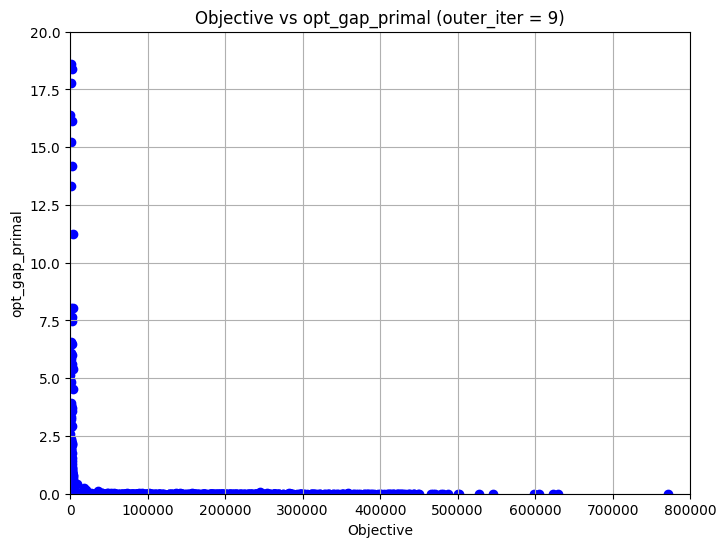

In [7]:
df_outer9 = df[df['outer_iter'] == 9]

# Scatter plot: Objective vs opt_gap_primal
plt.figure(figsize=(8, 6))
plt.scatter(df_outer9['objective'], df_outer9['opt_gap_primal'], color='blue')

plt.xlabel('Objective')
plt.ylabel('opt_gap_primal')
plt.title('Objective vs opt_gap_primal (outer_iter = 9)')
plt.ylim(0, 20)  # zoom in on y-axis
plt.xlim(0,800000)
plt.grid(True)
plt.show()

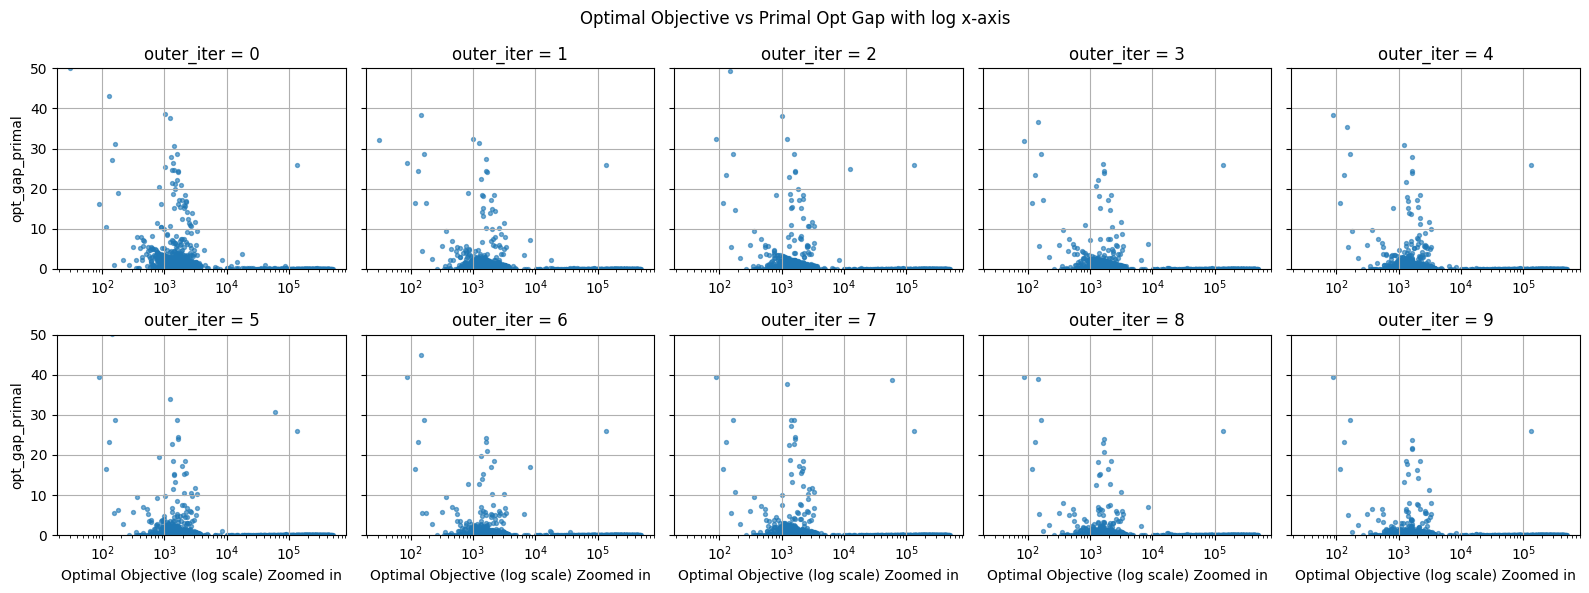

In [8]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 5, figsize=(16, 6), sharex=False, sharey=True)
axes = axes.ravel()

for k in range(10):
    d = df[(df['outer_iter'] == k) & (df['objective'] < 500000)] # Most objective values are below 500,000
    ax = axes[k]
    ax.scatter(d['objective'], d['opt_gap_primal'], s=8, alpha=0.6)
    ax.set_xscale('log')
    ax.set_ylim(0, 50)  # zoom in on y-axis
    ax.set_title(f'outer_iter = {k}')
    ax.grid(True)

axes[0].set_ylabel('opt_gap_primal')
axes[5].set_ylabel('opt_gap_primal')
for ax in axes[5:]:
    ax.set_xlabel('Optimal Objective (log scale) Zoomed in')

fig.suptitle('Optimal Objective vs Primal Opt Gap with log x-axis')
plt.tight_layout()
plt.show()


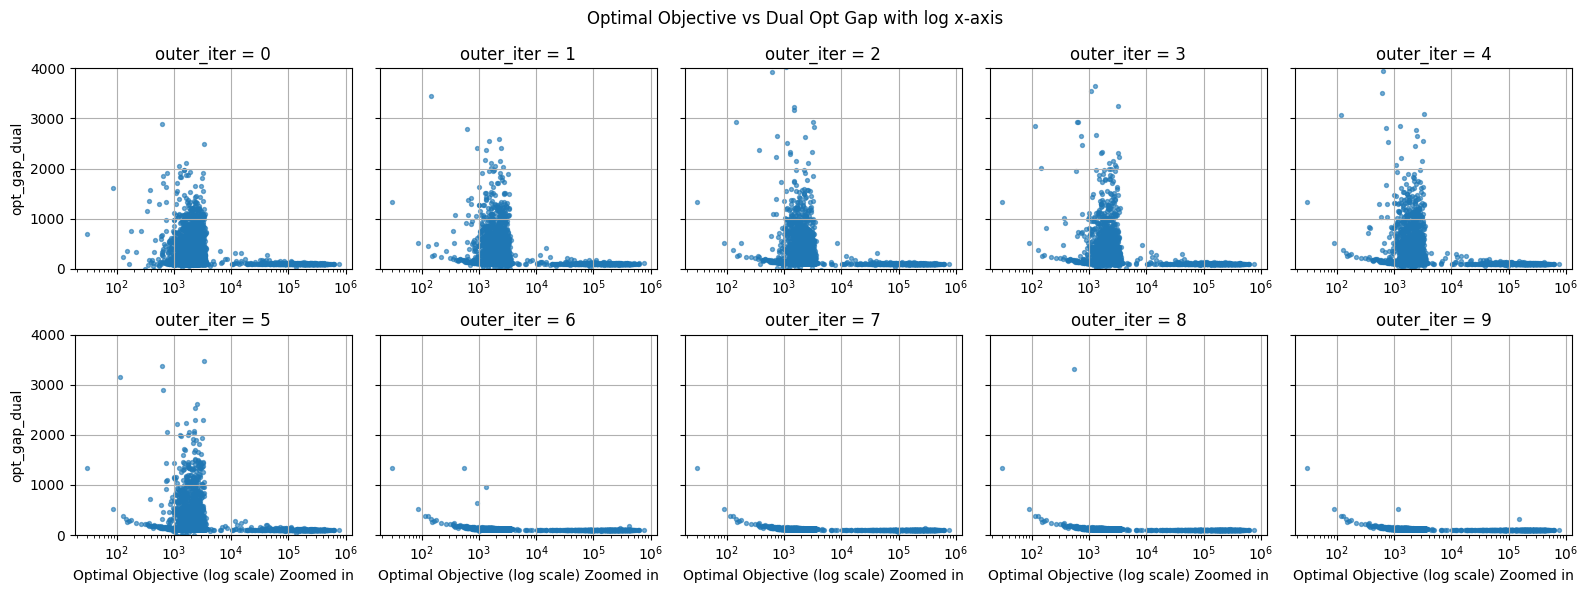

In [9]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 5, figsize=(16, 6), sharex=False, sharey=True)
axes = axes.ravel()

for k in range(10):
    d = df[(df['outer_iter'] == k) & (df['objective'] < 800000)] # Most objective values are below 500,000
    ax = axes[k]
    ax.scatter(d['objective'], d['opt_gap_dual'], s=8, alpha=0.6)
    ax.set_title(f'outer_iter = {k}')
    ax.set_xscale('log')
    ax.set_ylim(0, 4000)  # zoom in on y-axis
    ax.grid(True)

axes[0].set_ylabel('opt_gap_dual')
axes[5].set_ylabel('opt_gap_dual')
for ax in axes[5:]:
    ax.set_xlabel('Optimal Objective (log scale) Zoomed in')

fig.suptitle('Optimal Objective vs Dual Opt Gap with log x-axis')
plt.tight_layout()
plt.show()


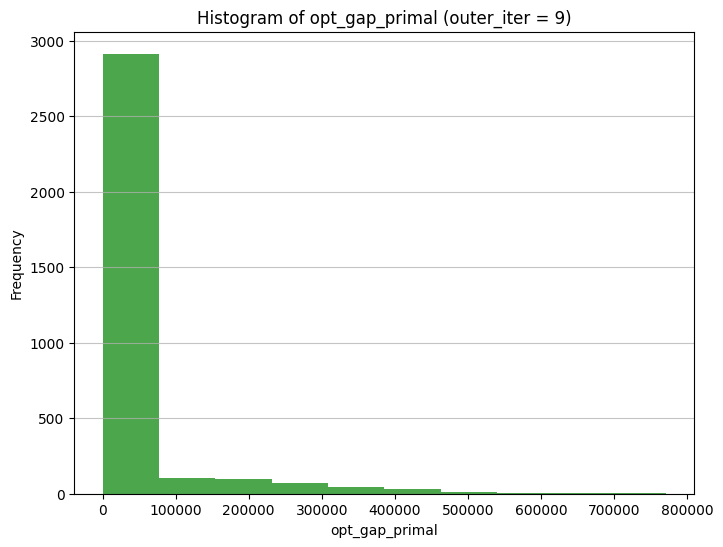

In [10]:
# plot histogram of df_outer9

plt.figure(figsize=(8, 6))
plt.hist(df_outer9['objective'], bins=10, color='green', alpha=0.7)
plt.xlabel('opt_gap_primal')
plt.ylabel('Frequency')
plt.title('Histogram of opt_gap_primal (outer_iter = 9)')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [11]:
def plot_gap_against_opt_obj(path, key_title):
    df = pd.read_csv(path)


    # Plot primal
    fig, axes = plt.subplots(2, 5, figsize=(16, 6), sharex=False, sharey=True)
    axes = axes.ravel()

    for k in range(10):
        d = df[(df['outer_iter'] == k) & (df['objective'] < 500000)] # Most objective values are below 500,000
        ax = axes[k]
        ax.scatter(d['objective'], d['opt_gap_primal'], s=8, alpha=0.6)
        ax.set_xscale('log')
        ax.set_ylim(0, 50)  # zoom in on y-axis
        ax.set_title(f'outer_iter = {k}')
        ax.grid(True)

    axes[0].set_ylabel('opt_gap_primal')
    axes[5].set_ylabel('opt_gap_primal')
    for ax in axes[5:]:
        ax.set_xlabel('Optimal Objective (log scale) Zoomed in')
    fig.suptitle(f'{key_title}: Opt Obj vs Primal Opt Gap with log x-axis')
    plt.tight_layout()
    plt.show()

    # Plot dual
    fig, axes = plt.subplots(2, 5, figsize=(16, 6), sharex=False, sharey=True)
    axes = axes.ravel()

    for k in range(10):
        d = df[(df['outer_iter'] == k) & (df['objective'] < 800000)] # Most objective values are below 500,000
        ax = axes[k]
        ax.scatter(d['objective'], d['opt_gap_dual'], s=8, alpha=0.6)
        ax.set_title(f'outer_iter = {k}')
        ax.set_xscale('log')
        ax.set_ylim(0, 4000)  # zoom in on y-axis
        ax.grid(True)

    axes[0].set_ylabel('opt_gap_dual')
    axes[5].set_ylabel('opt_gap_dual')
    for ax in axes[5:]:
        ax.set_xlabel('Optimal Objective (log scale) Zoomed in')

    fig.suptitle(f'{key_title}: Opt Obj vs Dual Opt Gap with log x-axis')
    plt.tight_layout()
    plt.show()



In [12]:
!ls outputs/PDL/ED/learn_primal:True_train:0.8_rho:0.5_rhomax:5000_alpha:10_L:10-1761917514-639512NormRepairAll/repeat:0

ls: outputs/PDL/ED/learn_primal:True_train:0.8_rho:0.5_rhomax:5000_alpha:10_L:10-1761917514-639512NormRepairAll/repeat:0: No such file or directory


exp_path: learn_primal:True_train:0.8_rho:0.5_rhomax:5000_alpha:10_L:10-Log
metric_file: outputs/PDL/ED/learn_primal:True_train:0.8_rho:0.5_rhomax:5000_alpha:10_L:10-Log/repeat:0/eval_metrics_NormLog.csv


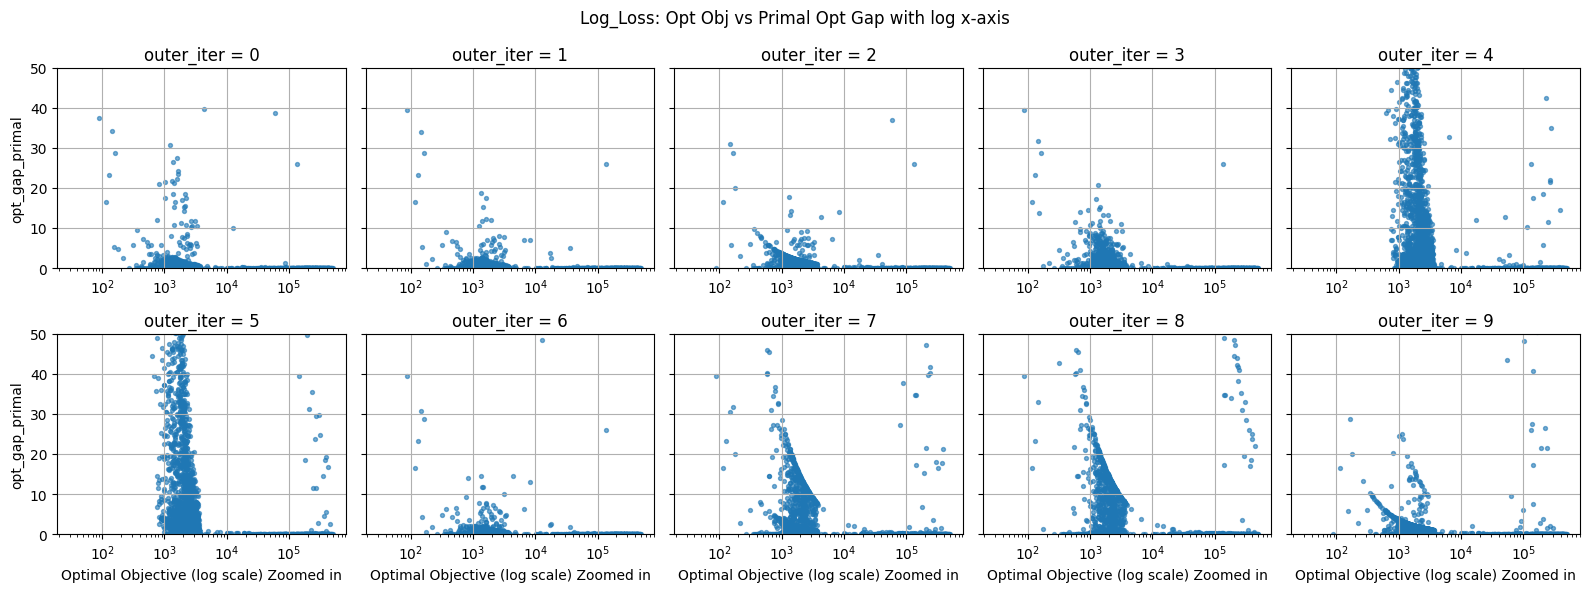

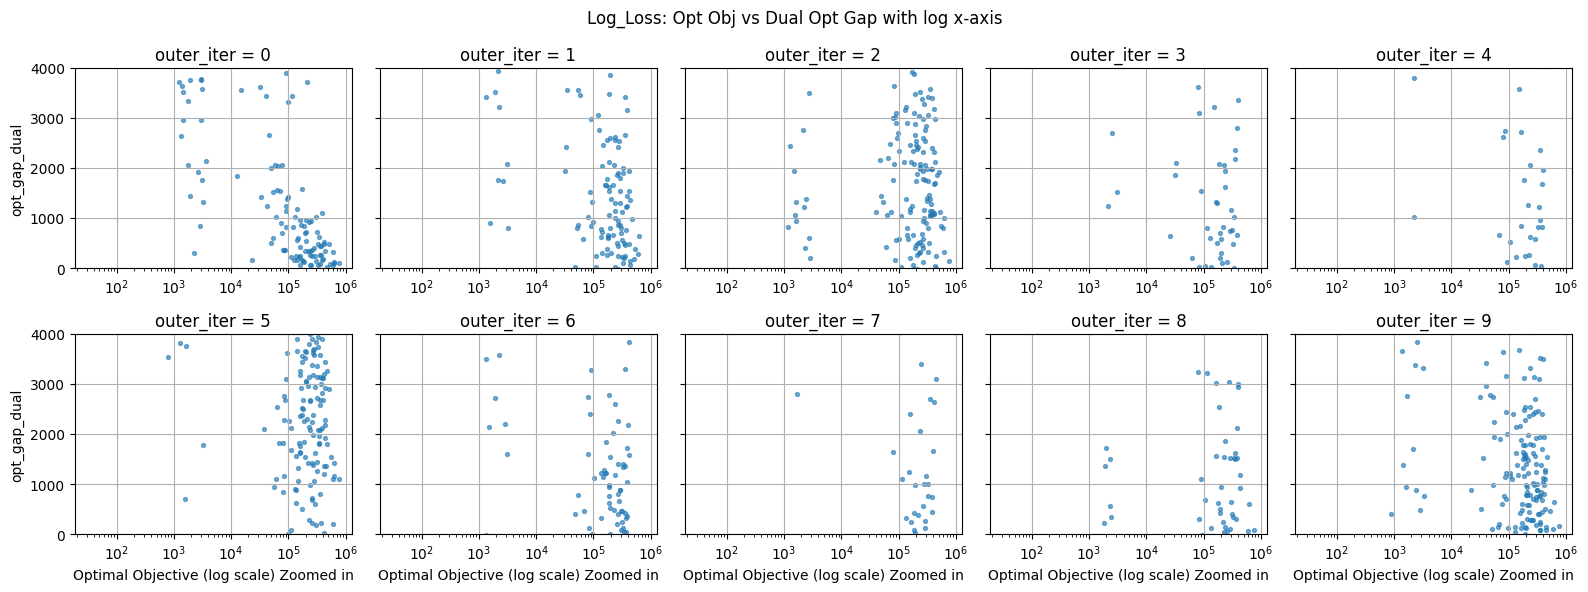

In [13]:
import os
setting = "Log"
exp_path = f"learn_primal:True_train:0.8_rho:0.5_rhomax:5000_alpha:10_L:10-{setting}"
metric_file = os.path.join("outputs/PDL/ED", exp_path, f"repeat:0/eval_metrics_Norm{setting}.csv")
print(f"exp_path: {exp_path}")
print(f"metric_file: {metric_file}")
name = f"{setting}_Loss"
plot_gap_against_opt_obj(metric_file, name)

In [14]:
!pwd

/Users/peterhuang/Desktop/Delft/Year-2/masterthesis


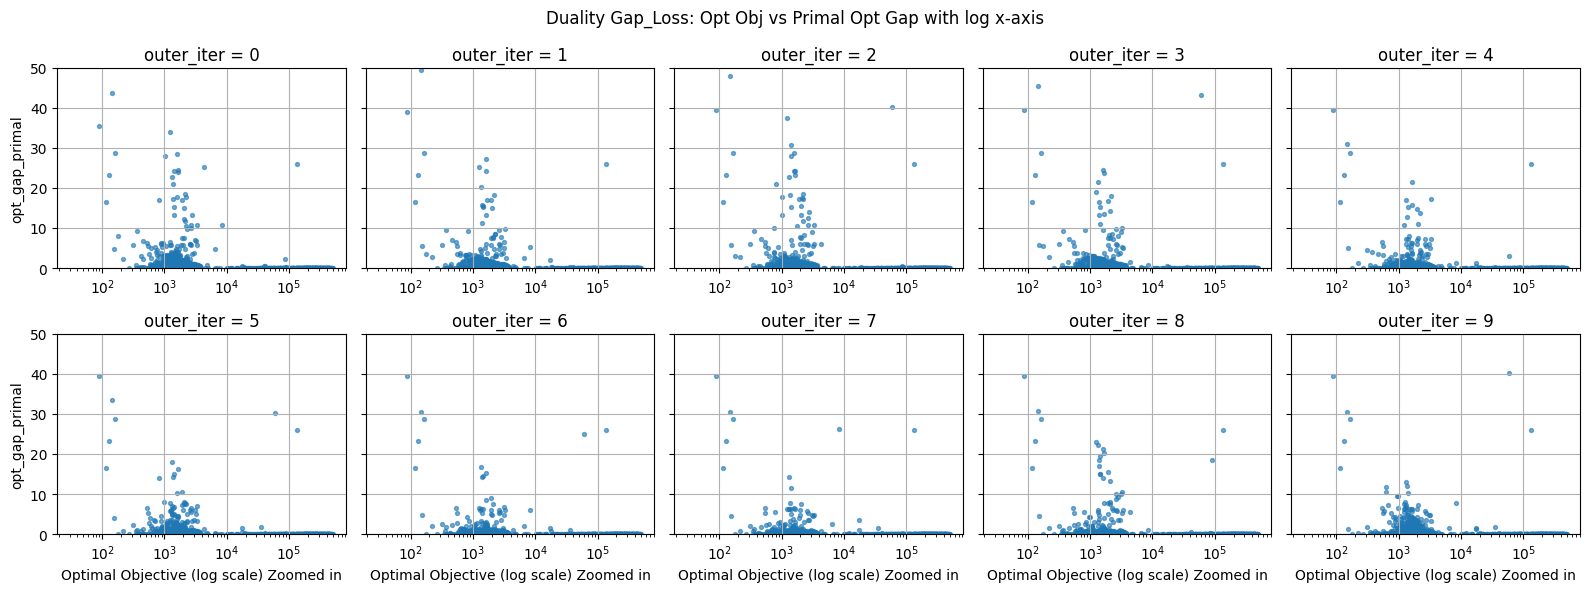

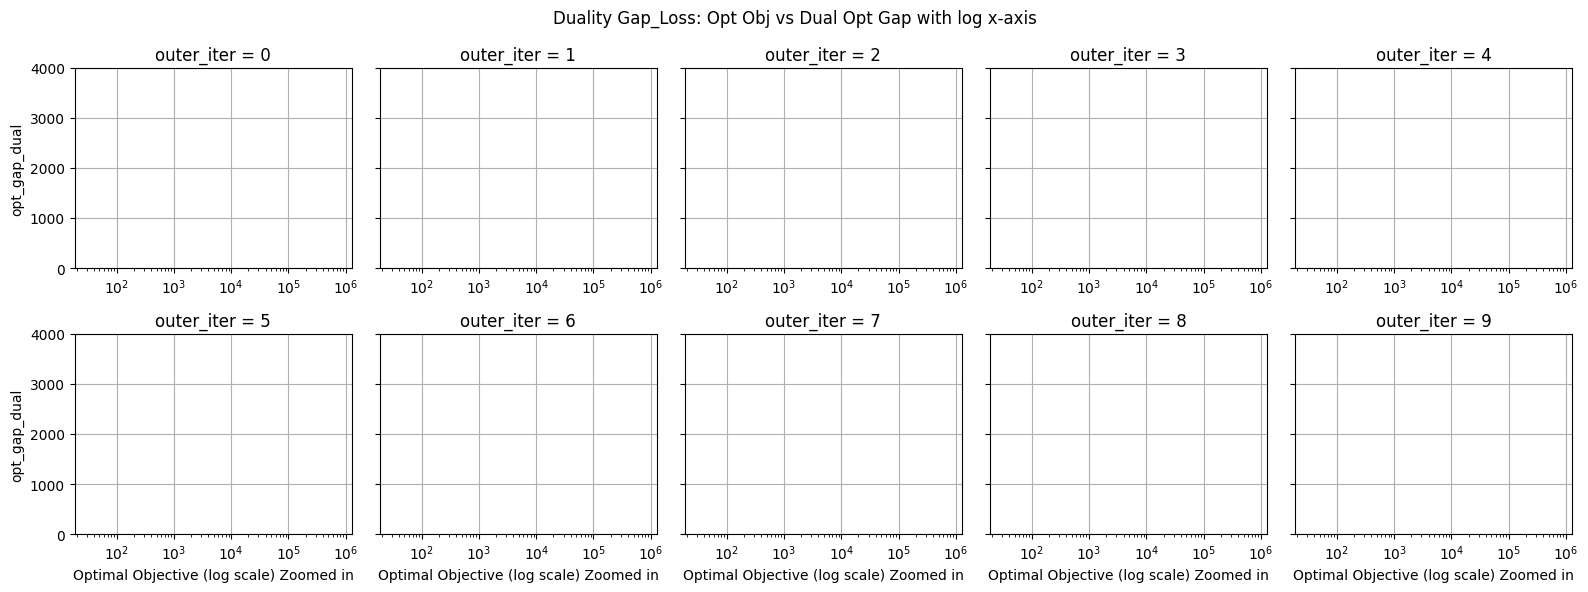

In [15]:
import os
exp_path = "learn_primal:True_train:0.8_rho:0.5_rhomax:5000_alpha:10_L:10-DualityGap"
metric_file = os.path.join("outputs/PDL/ED", exp_path, "repeat:0/eval_metrics_NormDuality_Gap.csv")
setting = "Duality Gap"
name = f"{setting}_Loss"
plot_gap_against_opt_obj(metric_file, name)

In [16]:
!ls outputs/PDL/ED/learn_primal:True_train:0.8_rho:0.5_rhomax:5000_alpha:10_L:10-NoNormRepairAll/repeat:0

dual_weights.pth
duality_gap.png
eval_metrics_NormFalse.csv
events.out.tfevents.1761919180.Peters-MacBook-Pro.local.23877.0
opt_gap_dual.png
opt_gap_primal.png
opt_gap_primal_dual.png
primal_weights.pth
train_time.txt


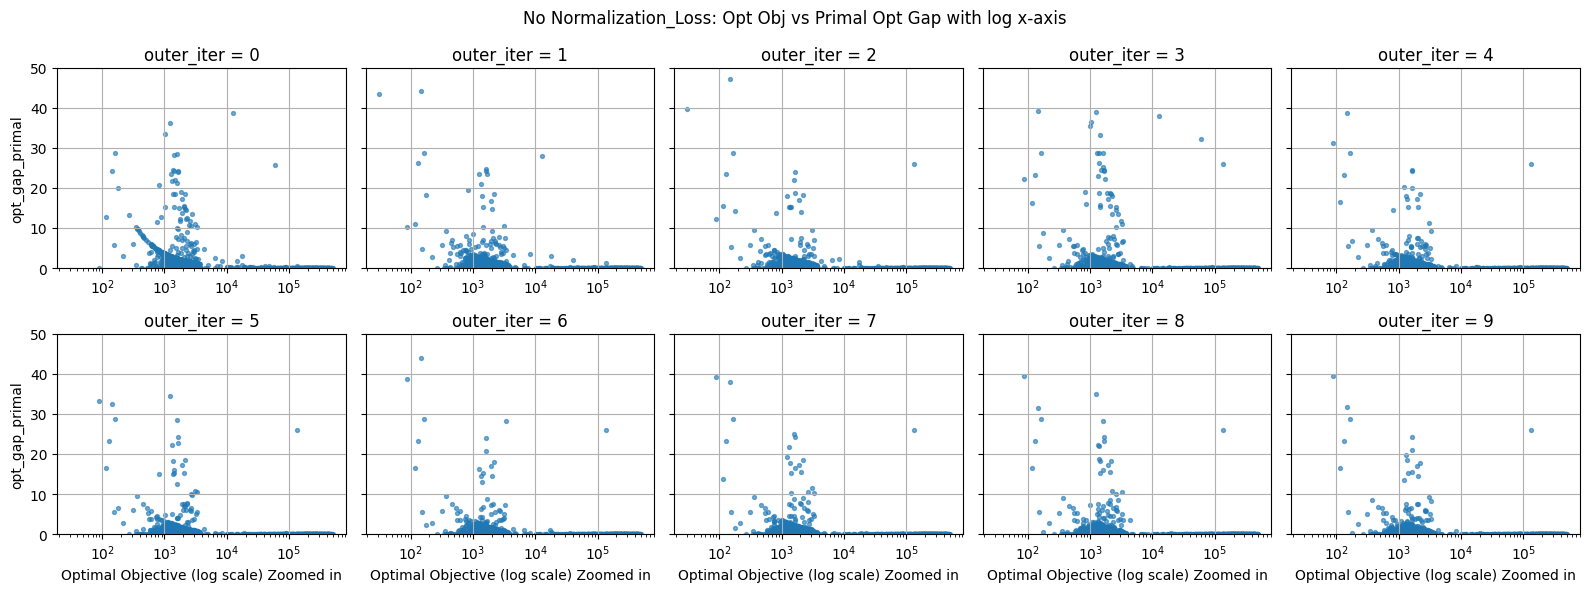

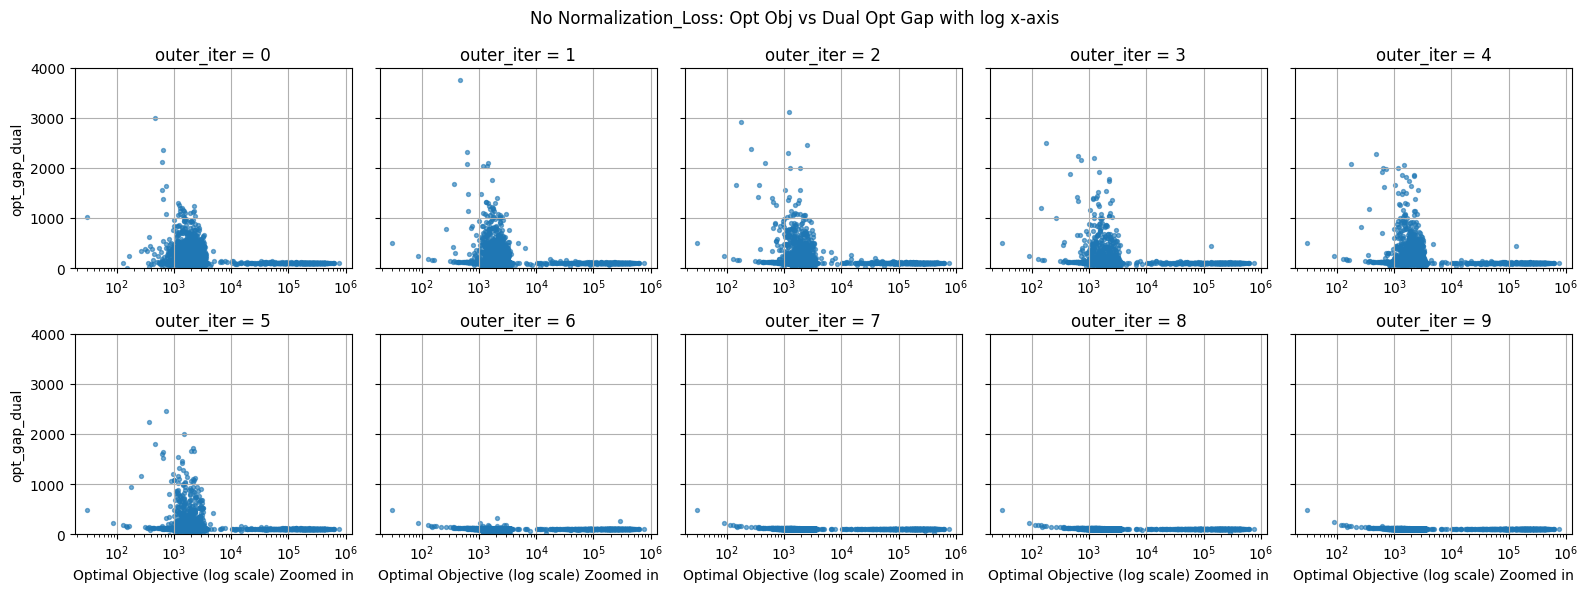

In [17]:
import os
exp_path = "learn_primal:True_train:0.8_rho:0.5_rhomax:5000_alpha:10_L:10-NoNormRepairAll"
metric_file = os.path.join("outputs/PDL/ED", exp_path, "repeat:0/eval_metrics_NormFalse.csv")
setting = "No Normalization"
name = f"{setting}_Loss"
plot_gap_against_opt_obj(metric_file, name)

In [18]:
!ls outputs/PDL/ED/learn_primal:True_train:0.8_rho:0.5_rhomax:5000_alpha:10_L:10-NormRepairWithoutGT/repeat:0

dual_weights.pth
duality_gap.png
eval_metrics_NormTrue.csv
events.out.tfevents.1763211010.Peters-MacBook-Pro.local.30648.0
opt_gap_dual.png
opt_gap_primal.png
opt_gap_primal_dual.png
primal_weights.pth
train_time.txt


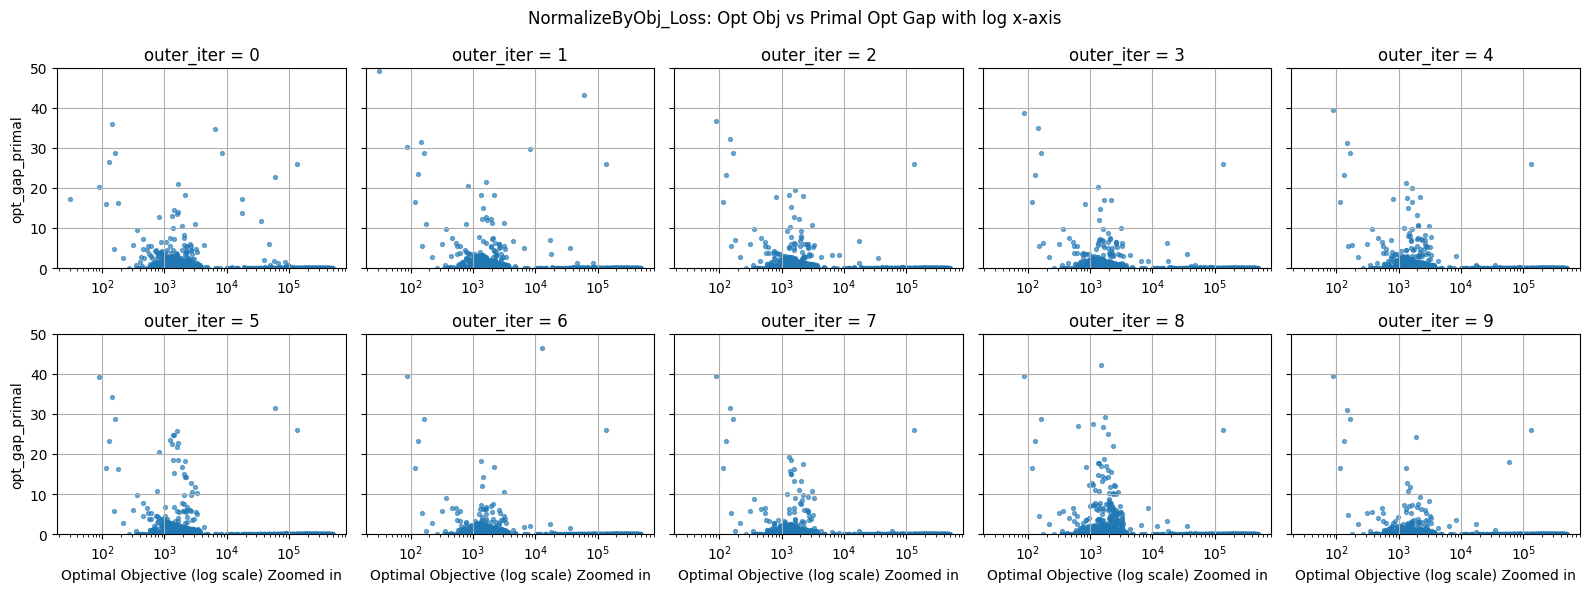

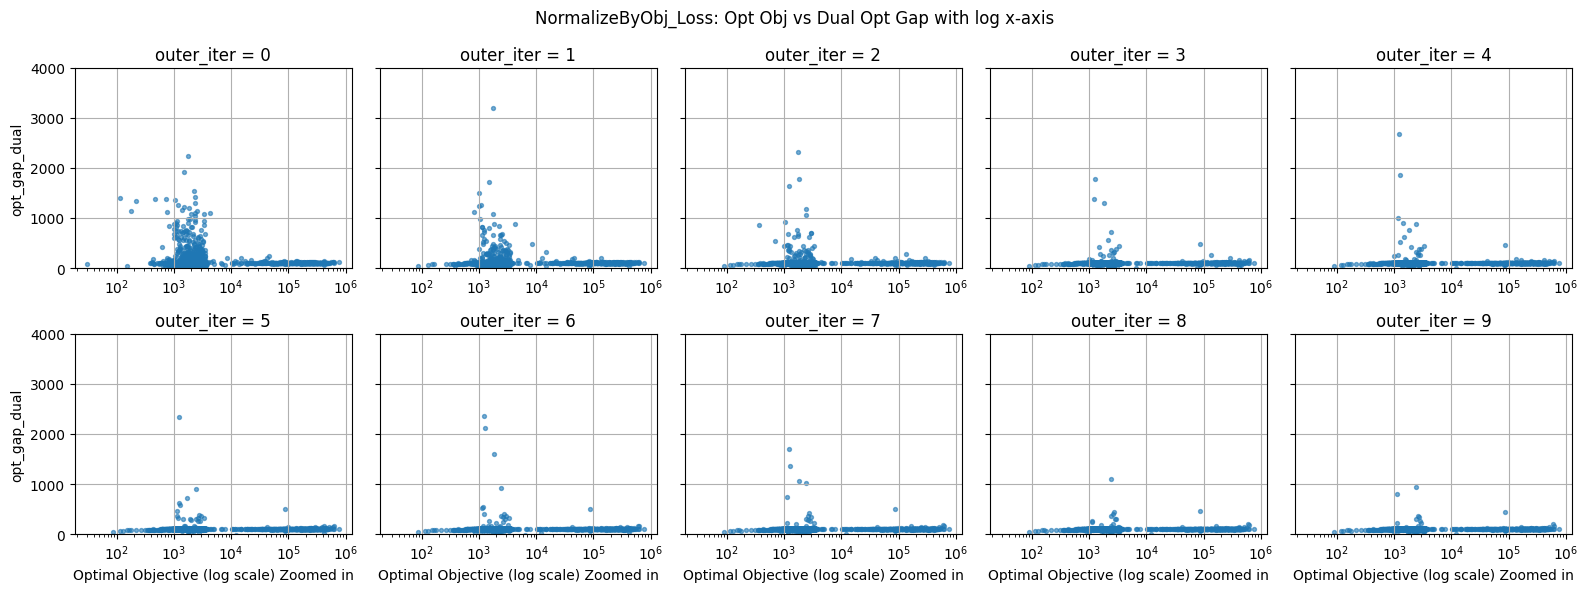

In [19]:


exp_path = "learn_primal:True_train:0.8_rho:0.5_rhomax:5000_alpha:10_L:10-NormRepairWithoutGT"
metric_file = os.path.join("outputs/PDL/ED", exp_path, "repeat:0/eval_metrics_NormTrue.csv")
setting = "NormalizeByObj"
name = f"{setting}_Loss"
plot_gap_against_opt_obj(metric_file, name)

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def bin_gap_vs_objective_and_plot_multi_mean_only(
    csv_paths,
    csv_names,
    gap_col,
    obj_col,
    n_bins,
    use_quantile_bins=True,
):
    """
    Multi-method binning analysis:
    - Bins on gap_col (common bins).
    - Computes mean(obj) inside each bin.
    - Returns wide table: rows=methods, cols=bins.
    - Plots mean obj vs bin index.
    """

    dfs = []

    # ------------------------------
    # Load and clean all CSVs
    # ------------------------------
    for p in csv_paths:
        df = pd.read_csv(p)
        df = df[df['outer_iter'] == 9]
        print(df.head())
        mask = np.isfinite(df[gap_col]) & np.isfinite(df[obj_col])
        df = df.loc[mask, [gap_col, obj_col]].copy()
        dfs.append(df)

    # Build global bin edges **based on objective**
    full = pd.concat(dfs, ignore_index=True)
    obj_values = full[obj_col].values

    if use_quantile_bins:
        _, bins = pd.qcut(obj_values, q=n_bins, retbins=True, duplicates="drop")
    else:
        bins = np.linspace(obj_values.min(), obj_values.max(), n_bins + 1)


    # Prepare IntervalIndex (columns)
    intervals = pd.IntervalIndex.from_breaks(bins)

    # Pre-create tables with right columns
    mean_table = pd.DataFrame(index=csv_names, columns=intervals, dtype=float)
    count_table = pd.DataFrame(index=csv_names, columns=intervals, dtype=int)

    # Bin centers (for plotting)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    # ------------------------------
    # Process each CSV (method)
    # ------------------------------
    for name, df in zip(csv_names, dfs):

        df = df.copy()
        df["gap_bin"] = pd.cut(df[gap_col], bins=intervals)

        grouped = df.groupby("gap_bin")[obj_col]

        mean_vals = grouped.mean().reindex(intervals)
        count_vals = grouped.size().reindex(intervals, fill_value=0)

        mean_table.loc[name] = mean_vals.values
        count_table.loc[name] = count_vals.values

    # ------------------------------
    # Plot
    # ------------------------------
    plt.figure(figsize=(8, 5))
    for name in csv_names:
        plt.plot(bin_centers, mean_table.loc[name].astype(float).values,
                 marker="o", alpha=0.8, label=name)

    plt.xlabel(f"Binned {gap_col}")
    plt.ylabel(f"Mean {obj_col}")
    plt.title("Mean objective vs binned gap")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Rename columns to bin_0 ... bin_N
    mean_table.columns = [f"bin_{i}" for i in range(len(mean_table.columns))]

    print("\nCounts per bin per method:")
    print(count_table)

    return mean_table, bins


In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def bin_gap_vs_objective_and_plot_multi_mean_only(
    csv_paths,
    csv_names,
    gap_col,
    obj_col,
    n_bins,
    use_quantile_bins=True,
):
    """
    Multi-method binning analysis:
    - Bins on obj_col (NOT gap_col!).
    - Computes mean(gap) inside each bin.
    - Returns wide table: rows=methods, cols=bins.
    """

    dfs = []

    # ------------------------------
    # Load and clean all CSVs
    # ------------------------------
    i = 0
    for p in csv_paths:
        df = pd.read_csv(p)
        df = df[df['outer_iter'] == 9]   # keep only final iteration
        if i == 0:
            i == 1
        else:
            print(df.head())
        mask = np.isfinite(df[gap_col]) & np.isfinite(df[obj_col])
        df = df.loc[mask, [gap_col, obj_col]].copy()
        dfs.append(df)

    # Build global bin edges **based on objective**
    full = pd.concat(dfs, ignore_index=True)
    obj_values = full[obj_col].values

    if use_quantile_bins:
        _, bins = pd.qcut(obj_values, q=n_bins, retbins=True, duplicates="drop")
    else:
        bins = np.linspace(obj_values.min(), obj_values.max(), n_bins + 1)

    # Prepare IntervalIndex
    intervals = pd.IntervalIndex.from_breaks(bins)

    # Pre-create tables with right columns
    mean_table = pd.DataFrame(index=csv_names, columns=intervals, dtype=float)
    count_table = pd.DataFrame(index=csv_names, columns=intervals, dtype=int)

    # ------------------------------
    # Process each CSV (method)
    # ------------------------------
    for name, df in zip(csv_names, dfs):

        df = df.copy()
        df["obj_bin"] = pd.cut(df[obj_col], bins=intervals)

        grouped = df.groupby("obj_bin")[gap_col]

        mean_vals = grouped.mean().reindex(intervals)
        count_vals = grouped.size().reindex(intervals, fill_value=0)

        mean_table.loc[name] = mean_vals.values
        count_table.loc[name] = count_vals.values

    # ------------------------------
    # Plot: bins on x, mean gap on y
    # ------------------------------
    plt.figure(figsize=(8, 5))
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    for name in csv_names:
        plt.plot(
            bin_centers,
            mean_table.loc[name].astype(float).values,
            marker="o",
            alpha=0.8,
            label=name
        )

    plt.xlabel(f"Binned {obj_col}")
    plt.ylabel(f"Mean {gap_col}")
    plt.title("Mean gap vs binned objective")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()

    print("\nCounts per bin per method:")
    print(count_table)

    return mean_table, bins


/var/folders/3n/3c918lz14kd61yk6hgz4s1x40000gn/T/ipykernel_1063/2698438126.py:62: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby("obj_bin")[gap_col]
/var/folders/3n/3c918lz14kd61yk6hgz4s1x40000gn/T/ipykernel_1063/2698438126.py:62: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby("obj_bin")[gap_col]
/var/folders/3n/3c918lz14kd61yk6hgz4s1x40000gn/T/ipykernel_1063/2698438126.py:62: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the f

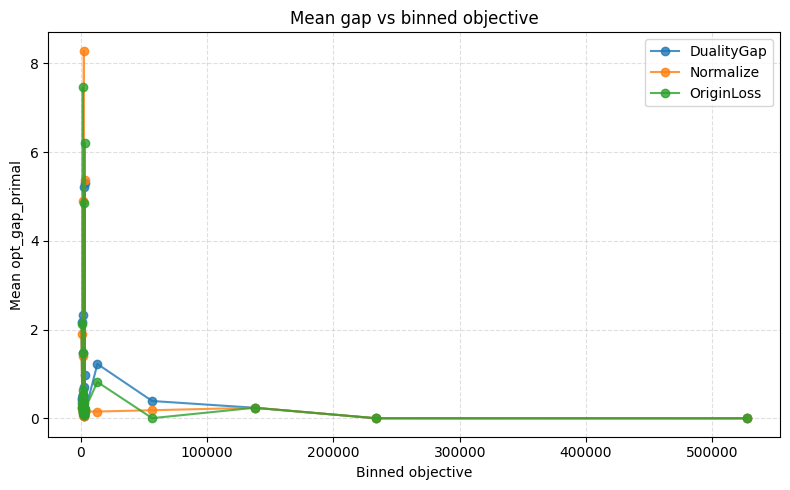


Counts per bin per method:
            (30.662570304218193, 950.595810458541]  \
DualityGap                                   109.0   
Normalize                                    109.0   
OriginLoss                                   109.0   

            (950.595810458541, 1133.3181077138902]  \
DualityGap                                   109.0   
Normalize                                    109.0   
OriginLoss                                   109.0   

            (1133.3181077138902, 1242.977817524488]  \
DualityGap                                    109.0   
Normalize                                     109.0   
OriginLoss                                    109.0   

            (1242.977817524488, 1331.769595685117]  \
DualityGap                                   109.0   
Normalize                                    109.0   
OriginLoss                                   109.0   

            (1331.769595685117, 1407.4836104884992]  \
DualityGap                                   

In [85]:
import os
import matplotlib.pyplot as plt

exp_paths = [
    "outputs/PDL/ED/learn_primal:True_train:0.8_rho:0.5_rhomax:5000_alpha:10_L:10-NormRepairAll",
    "outputs/PDL/ED/learn_primal:True_train:0.8_rho:0.5_rhomax:5000_alpha:10_L:10-NoNormRepairAll",
    "outputs/PDL/ED/learn_primal:True_train:0.8_rho:0.5_rhomax:5000_alpha:10_L:10-NormRepairWithoutGT",
    "outputs/PDL/ED/learn_primal:True_train:0.8_rho:0.5_rhomax:5000_alpha:10_L:10-DualityGap",
    "outputs/PDL/ED/learn_primal:True_train:0.8_rho:0.5_rhomax:5000_alpha:10_L:10-DualityGapNoNorm",
    "outputs/PDL/ED/learn_primal:True_train:0.8_rho:0.5_rhomax:5000_alpha:10_L:10-DualityGapNormMiddle",
    "outputs/PDL/ED/learn_primal:True_train:0.8_rho:0.5_rhomax:5000_alpha:10_L:10-NoPowerBlanaceRepairNoNorm",
    "outputs/PDL/ED/learn_primal:True_train:0.8_rho:0.5_rhomax:5000_alpha:10_L:10-DualClassDualityGap",
    "outputs/PDL/ED/learn_primal:True_train:0.8_rho:0.5_rhomax:5000_alpha:10_L:10-Log",
]

# Example of constructing metric file paths
setting1 = "Log"
setting2 = "DualityGap"

exp_path1 = f"learn_primal:True_train:0.8_rho:0.5_rhomax:5000_alpha:10_L:10-{setting1}"
metric_file1 = os.path.join("outputs/PDL/ED", exp_path1, f"repeat:0/eval_metrics_Norm{setting1}.csv")

exp_path2 = f"learn_primal:True_train:0.8_rho:0.5_rhomax:5000_alpha:10_L:10-{setting2}"
metric_file2 = os.path.join("outputs/PDL/ED", exp_path2, f"repeat:0/eval_metrics_NormDuality_Gap.csv")

exp_path3 = "learn_primal:True_train:0.8_rho:0.5_rhomax:5000_alpha:10_L:10-NoNormRepairAll"
metric_file3 = os.path.join("outputs/PDL/ED", exp_path3, "repeat:0/eval_metrics_NormFalse.csv")

exp_path4 = "learn_primal:True_train:0.8_rho:0.5_rhomax:5000_alpha:10_L:10-NormRepairWithoutGT"
metric_file4 = os.path.join("outputs/PDL/ED", exp_path4, "repeat:0/eval_metrics_NormTrue.csv")

csv_paths = [metric_file2, metric_file4, metric_file3]
csv_names = ["DualityGap", "Normalize", "OriginLoss"]

# -------------------------------
# THIS is how you called the function
# -------------------------------
bin_table, bins = bin_gap_vs_objective_and_plot_multi_mean_only(
    csv_paths=csv_paths,
    csv_names=csv_names,
    gap_col="opt_gap_primal",
    obj_col="objective",
    n_bins=30,
    use_quantile_bins=True
)

print(bin_table.head())


In [86]:
import numpy as np
import matplotlib.pyplot as plt

def plot_binned_gap_bars(mean_table, csv_names, bins, decimals=1, figsize=(14,6)):
    """
    mean_table: DataFrame returned by bin_gap_vs_objective_and_plot_multi_mean_only
    csv_names : list of method names (row order)
    bins      : array of bin boundaries (len = n_bins+1)
    decimals  : number of decimals for axis tick labels
    """

    # Convert data to numpy
    data = mean_table.loc[csv_names].astype(float).values
    n_methods, n_bins = data.shape

    x = np.arange(n_bins)
    width = 0.8 / n_methods

    # ---- Make readable X tick labels (LB–UB with 1 decimal) ----
    xtick_labels = [
        f"{bins[i]:.{decimals}f}–{bins[i+1]:.{decimals}f}"
        for i in range(len(bins)-1)
    ]

    plt.figure(figsize=figsize)

    for i, method in enumerate(csv_names):
        plt.bar(
            x + i * width,
            data[i],
            width,
            label=method
        )

    # Use formatted LB–UB tick labels
    plt.xticks(
        x + width*(n_methods-1)/2,
        xtick_labels,
        rotation=45,
        ha='right'
    )

    plt.xlabel("Objective Bins")
    plt.ylabel("Mean Gap (%)")
    plt.title("Method Comparison Across Objective Bins")
    plt.legend()
    plt.grid(True, axis='y', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()


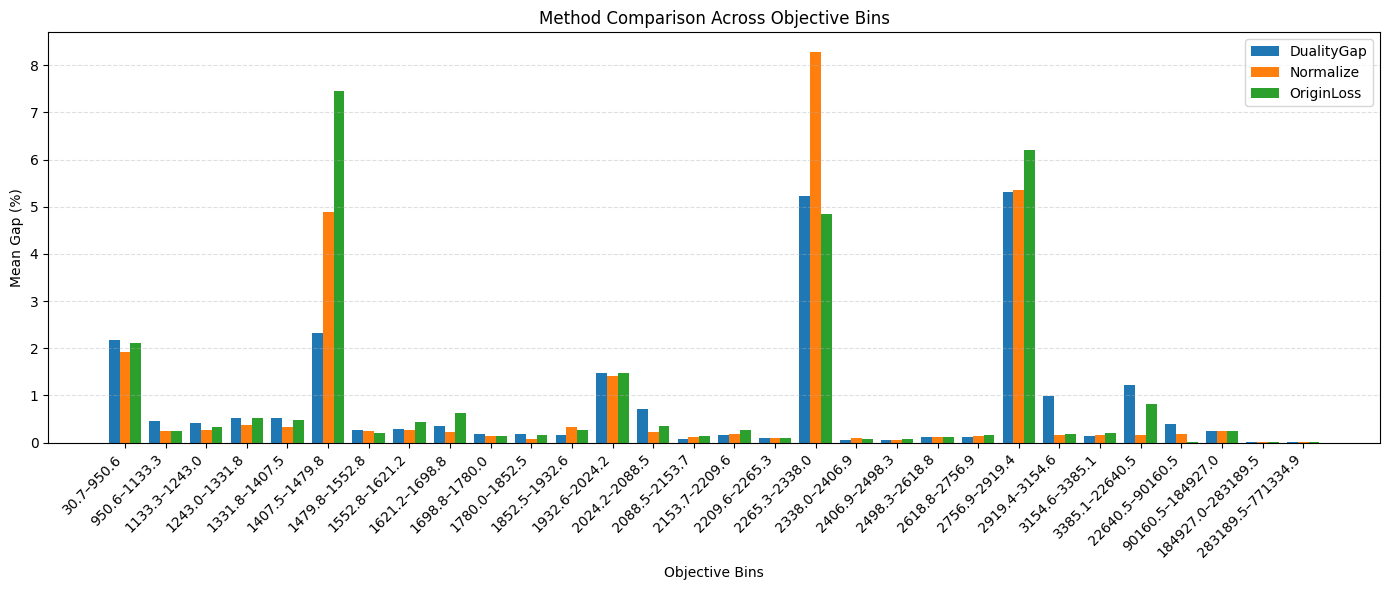

In [87]:
plot_binned_gap_bars(
    bin_table,
    csv_names,
    bins = bins,
    decimals = 1
)

In [54]:
intervals = pd.IntervalIndex.from_breaks(bins)

In [55]:
import numpy as np
import matplotlib.pyplot as plt

def plot_binned_gap_bars(mean_table, csv_names, intervals, decimals=1, figsize=(14,6)):
    """
    mean_table : DataFrame from the binning function
    csv_names  : list of method names in display order
    intervals  : IntervalIndex used for binning
    decimals   : decimal places for bin boundaries on x-axis
    """

    # Convert to numpy
    data = mean_table.loc[csv_names].astype(float).values  # (methods, bins)
    n_methods, n_bins = data.shape

    x = np.arange(n_bins)
    width = 0.8 / n_methods

    # ---- Format bin labels (lb–ub) ----
    xtick_labels = [
        f"{interval.left:.{decimals}f}–{interval.right:.{decimals}f}"
        for interval in intervals
    ]

    plt.figure(figsize=figsize)

    for i, method in enumerate(csv_names):
        plt.bar(
            x + i * width,
            data[i],
            width,
            label=method
        )

    plt.xticks(
        x + width * (n_methods - 1) / 2,
        xtick_labels,
        rotation=45,
        ha='right'
    )

    plt.xlabel("Gap Bins (lower–upper bounds)")
    plt.ylabel("Mean Objective")
    plt.title("Comparison of Methods: Mean Objective at Each Gap Bin")
    plt.legend()
    plt.grid(True, axis='y', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()


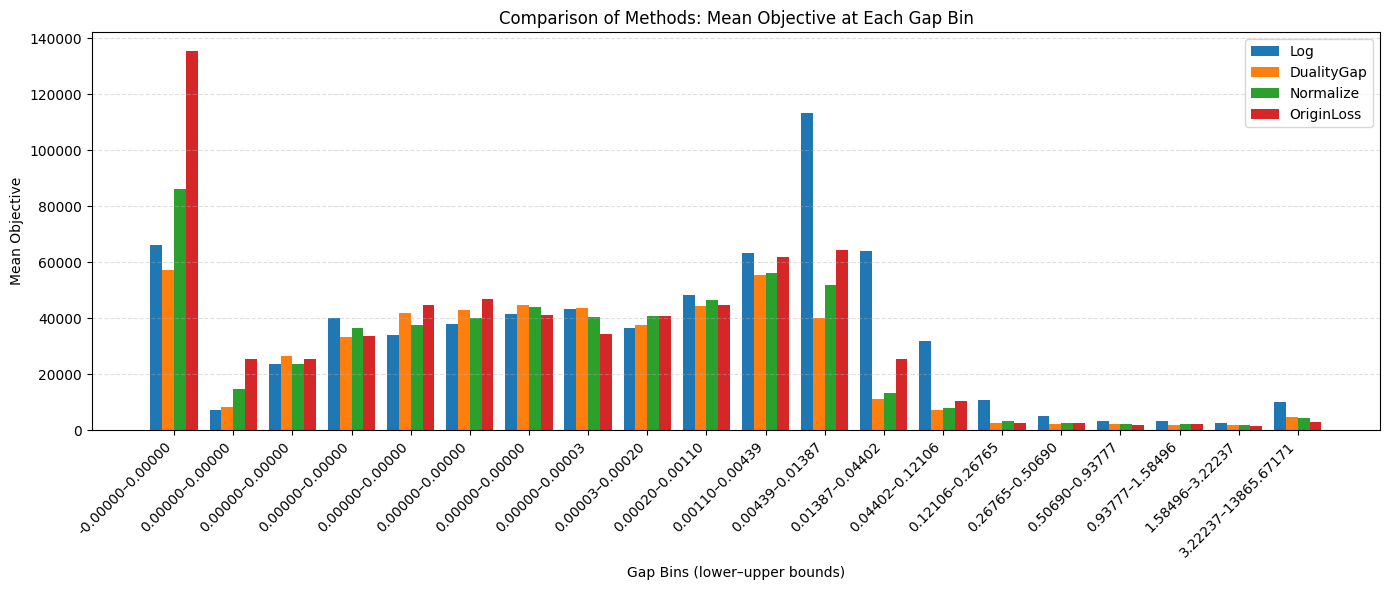

In [58]:
plot_binned_gap_bars(
    bin_table,
    csv_names,
    intervals=intervals,
    decimals=5
)

In [21]:
!ls outputs/PDL/ED/learn_primal:True_train:0.8_rho:0.5_rhomax:5000_alpha:10_L:10-NormRepairWithoutGT/repeat:0/

dual_weights.pth
duality_gap.png
eval_metrics_NormTrue.csv
events.out.tfevents.1763211010.Peters-MacBook-Pro.local.30648.0
opt_gap_dual.png
opt_gap_primal.png
opt_gap_primal_dual.png
primal_weights.pth
train_time.txt


In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import math

def plot_gap_vs_object(csv_path,
                       outer_iter_value=9,
                       obj_col='objective',
                       gap_col='opt_gap_primal',
                       outer_col='outer_iter',
                       x_cap=None,
                       y_cap=None,
                       alpha=0.4,
                       figsize=(12,5)):

    # Load
    df = pd.read_csv(csv_path)

    # Keep only last outer iteration
    df = df[df[outer_col] == outer_iter_value]

    # Filter finite values
    df = df[pd.notna(df[obj_col]) & pd.notna(df[gap_col])]

    # Optional caps
    if x_cap is not None:
        df = df[df[obj_col] < x_cap]
    if y_cap is not None:
        df = df[df[gap_col] < y_cap]

    print(f"Using {len(df)} rows from outer_iter = {outer_iter_value}")

    # Plot
    plt.figure(figsize=figsize)
    plt.scatter(df[obj_col], df[gap_col], s=12, alpha=alpha)
    plt.xscale('log')
    plt.xlabel("Objective value")
    plt.ylabel("Optimality gap")
    plt.title(f"opt_gap vs objective (outer_iter = {outer_iter_value})")
    plt.grid(alpha=0.25)

    plt.tight_layout()
    plt.show()

    return df


outputs/PDL/ED/learn_primal:True_train:0.8_rho:0.5_rhomax:5000_alpha:10_L:10-Log/repeat:0/eval_metrics_NormLog.csv
Using 3276 rows from outer_iter = 9


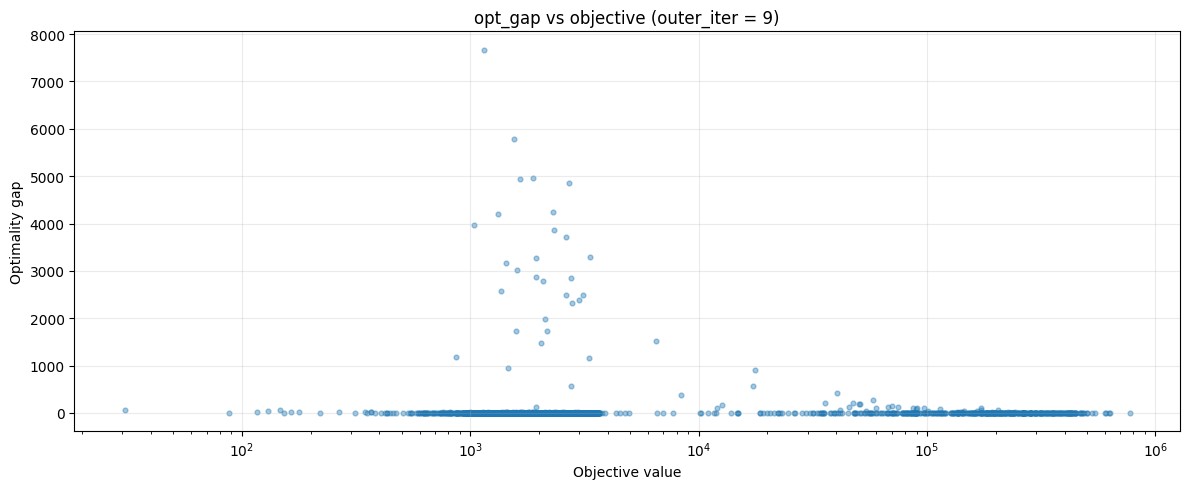

Using 3276 rows from outer_iter = 9


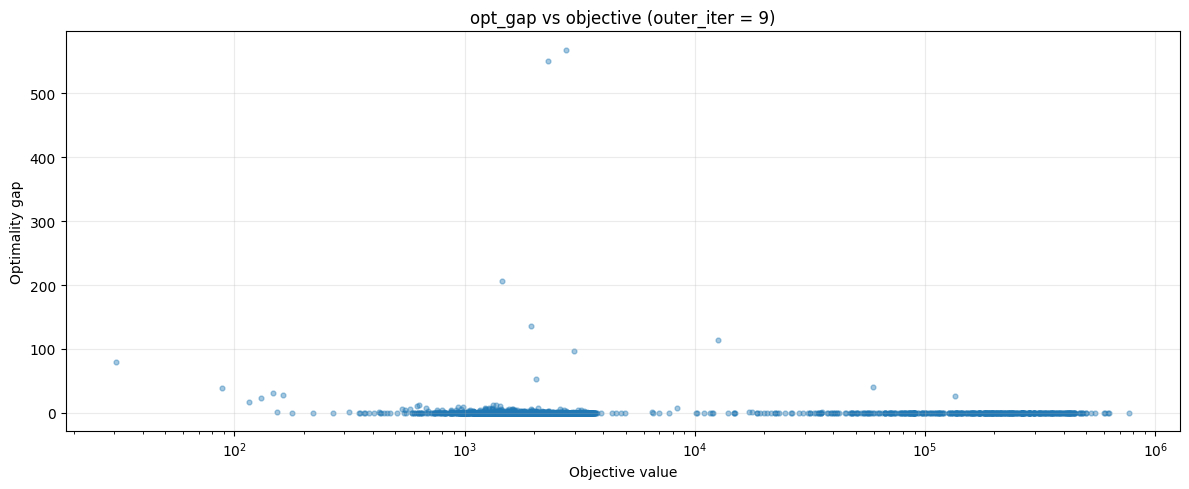

,outer_iter,inner_iter,objective,primal_obj,dual_obj_target,dual_obj,opt_gap_primal,opt_gap_dual
29484,9,99,2547.919251,2547.919941,2547.919251,-7.587524e+17,2.705175e-05,2.977929e+16
29485,9,99,1808.910090,1809.779704,1808.910090,-1.023698e+18,4.807393e-02,5.659200e+16
29486,9,99,2428.447060,2428.447060,2428.447060,-1.437326e+18,7.490340e-13,5.918705e+16
29487,9,99,2395.093764,2395.097105,2395.093764,-2.087117e+18,1.395127e-04,8.714134e+16
29488,9,99,2690.598315,2702.301286,2690.598315,-9.181678e+17,4.349579e-01,3.412504e+16
...,...,...,...,...,...,...,...,...
32755,9,99,2304.678203,2304.678203,2304.678203,-4.237128e+17,5.061127e-11,1.838490e+16
32756,9,99,883.246866,883.459022,883.246866,-5.715265e+17,2.402001e-02,6.470745e+16
32757,9,99,2602.165371,2602.638504,2602.165371,-4.834571e+17,1.818229e-02,1.857903e+16
32758,9,99,1474.302111,1474.334342,1474.302111,-1.100596e+18,2.186198e-03,7.465198e+16


In [23]:
setting1 = "Log"
setting2 = "DualityGap"
exp_path1 = f"learn_primal:True_train:0.8_rho:0.5_rhomax:5000_alpha:10_L:10-{setting1}"
metric_file1 = os.path.join("outputs/PDL/ED", exp_path1, f"repeat:0/eval_metrics_Norm{setting1}.csv")
print(metric_file1)
exp_path2 = f"learn_primal:True_train:0.8_rho:0.5_rhomax:5000_alpha:10_L:10-{setting2}"
metric_file2 = os.path.join("outputs/PDL/ED", exp_path2, f"repeat:0/eval_metrics_NormDuality_Gap.csv")

exp_path3 = "learn_primal:True_train:0.8_rho:0.5_rhomax:5000_alpha:10_L:10-NoNormRepairAll"
metric_file3 = os.path.join("outputs/PDL/ED", exp_path3, "repeat:0/eval_metrics_NormFalse.csv")

exp_path4 = "learn_primal:True_train:0.8_rho:0.5_rhomax:5000_alpha:10_L:10-NormRepairWithoutGT"
metric_file4 = os.path.join("outputs/PDL/ED", exp_path4, "repeat:0/eval_metrics_NormTrue.csv")
plot_gap_vs_object(
    csv_path=metric_file1,
    outer_iter_value=9,   # last outer iteration
    obj_col='objective',
    gap_col='opt_gap_primal'
)
plot_gap_vs_object(
    csv_path=metric_file2,
    outer_iter_value=9,   # last outer iteration
    obj_col='objective',
    gap_col='opt_gap_primal'
)

# Compute the specifc metrics regarding overfitting

In [24]:
# ---------------------------------------------------------
# 1. Collect per-sample data for stratified analysis
# ---------------------------------------------------------
all_rows = []

for run, (path, name) in enumerate(zip(
    exp_paths,
    ["NoPowerBalanceRepair", "RepairAll-NoNorm", "RepairAll-NormwithGT",
     "RepairAll-NormwithObj","RepairAll-DualityGap",
     "DualityGapNormMiddle","RepairAll-Log"]
)):

    # Load args.json
    with open(os.path.join(path, "args.json"), "r") as f:
        args = json.load(f)

    # Build test indices
    N = data.X.shape[0]
    train_size = int(args["train"] * N)
    valid_size = int(args["valid"] * N)
    test_indices = torch.arange(train_size + valid_size, N)
    if args['hidden_size_factor'] is False:
        args['hidden_size_factor'] = 28  # Set as this for some reason
    # Load primal network
    primal_net = PrimalNetEndToEnd(args, data=data)
    directory = os.path.join(path, "repeat:0")
    primal_net.load_state_dict(
        torch.load(os.path.join(directory, "primal_weights.pth"), weights_only=True)
    )
    primal_net.eval()

    # -------- per sample evaluation (not averages) ----------
    Xtest = data.X[test_indices]
    Ytarget = data.opt_targets["y_operational"][test_indices]
    Ypred = primal_net(Xtest)

    obj_pred = data.obj_fn(Xtest, Ypred).detach().numpy()
    obj_true = data.obj_fn(Xtest, Ytarget).detach().numpy()
    opt_gap = (obj_pred - obj_true) / np.abs(obj_true) * 100

    # Store each sample as a row
    for obj_val, gap_val in zip(obj_true, opt_gap):
        all_rows.append({
            "method": name,
            "objective": float(obj_val),
            "opt_gap": float(gap_val)
        })

# Convert to DataFrame
df = pd.DataFrame(all_rows)
print("Collected per-sample table:")
print(df.head())


Collected per-sample table:
                 method      objective       opt_gap
0  NoPowerBalanceRepair  278147.776732  4.792424e-06
1  NoPowerBalanceRepair    1746.442221  3.647093e-07
2  NoPowerBalanceRepair     936.505544  6.207182e-05
3  NoPowerBalanceRepair    2771.797418  2.756080e-02
4  NoPowerBalanceRepair    1413.293164  6.127777e-01


In [25]:
def stratified_gap(df, n_bins=5, log_obj=True):
    d = df.copy()

    # Make sure objective is numeric and avoid zeros/negatives
    obj = pd.to_numeric(d["objective"], errors="coerce")
    obj = obj.clip(lower=1e-6)  # <-- use 'lower' instead of 'min'

    if log_obj:
        d["obj_bin_key"] = np.log10(obj)
    else:
        d["obj_bin_key"] = obj

    # Also ensure gaps are numeric
    d["opt_gap"] = pd.to_numeric(d["opt_gap"], errors="coerce")

    # Drop any rows with NaNs
    d = d.replace([np.inf, -np.inf], np.nan).dropna(subset=["obj_bin_key", "opt_gap"])

    # Equal-count quantile bins on the (log) objective
    d["obj_bin"] = pd.qcut(d["obj_bin_key"], q=n_bins, duplicates="drop")

    grouped = d.groupby(["method", "obj_bin"])

    stats = grouped["opt_gap"].agg(["count", "mean", "median", "std"]).reset_index()
    return stats


In [26]:

def make_wide_gap_table(df, n_bins=5, log_obj=True):
    d = df.copy()

    # Clean / numeric
    obj = pd.to_numeric(d["objective"], errors="coerce").clip(lower=1e-6)
    if log_obj:
        d["obj_bin_key"] = np.log10(obj)
    else:
        d["obj_bin_key"] = obj

    d["opt_gap"] = pd.to_numeric(d["opt_gap"], errors="coerce")
    d = d.replace([np.inf, -np.inf], np.nan).dropna()

    # Create objective bins (quantile bins)
    d["obj_bin"] = pd.qcut(d["obj_bin_key"], q=n_bins, duplicates="drop")

    # Compute mean gap in each bin per method
    pivot = d.pivot_table(
        index="method",
        columns="obj_bin",
        values="opt_gap",
        aggfunc="mean"
    )

    return pivot, d

stats = stratified_gap(df, n_bins=5, log_obj=True)

# print("\n=== Stratified Gap by Objective Bins ===")
# print(stats)

# # Optional: pretty table per method
# for m in df["method"].unique():
#     print(f"\n\n===== {m} =====")
#     print(stats[stats["method"] == m].sort_values("obj_bin"))


gap_table, d_binned = make_wide_gap_table(df, n_bins=5, log_obj=True)
print("\n=== Mean gap per bin per method (wide table) ===\n")
gap_table



=== Mean gap per bin per method (wide table) ===



/var/folders/3n/3c918lz14kd61yk6hgz4s1x40000gn/T/ipykernel_1063/4288797529.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = d.groupby(["method", "obj_bin"])
/var/folders/3n/3c918lz14kd61yk6hgz4s1x40000gn/T/ipykernel_1063/2803731382.py:18: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = d.pivot_table(


obj_bin,"(1.9080000000000001, 3.166]","(3.166, 3.282]","(3.282, 3.371]","(3.371, 3.5]","(3.5, 5.967]"
method,,,,,
DualityGapNormMiddle,58.692688,26.762939,22.969581,18.612119,6.136920
NoPowerBalanceRepair,0.709894,0.329755,0.639977,1.266147,0.061158
RepairAll-DualityGap,0.639971,0.279410,0.576141,1.244440,0.025569
RepairAll-Log,10044.926771,6004.943798,4615.267498,3710.266097,975.381601
RepairAll-NoNorm,3.355468,2.062520,1.967349,2.296891,0.266672
RepairAll-NormwithGT,0.906241,0.450394,0.781820,1.348732,0.082269
RepairAll-NormwithObj,0.474256,0.410005,0.708171,1.778497,0.080246
